## makemore: part 5 (building a WaveNet)

[DeepMind blog post from 2016](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)

In [78]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [191]:
# read in all the words
words = open('./data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [192]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [193]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [194]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [195]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [196]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
# pytorch has an embedding class that does this
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
# pytorch also has flatten that is similar
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C * self.n)

    # If we have an unnecessary dimension, we squeeze it out
    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [197]:
torch.manual_seed(42); # seed rng for reproducibility

In [203]:
# original network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

# Below line No longer needed due to Embedding layer
# C = torch.randn((vocab_size, n_embd))

# model = Sequential([
#   Embedding(vocab_size, n_embd), 
#   FlattenConsecutive(8),
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

model = Sequential([
  Embedding(vocab_size, n_embd), 
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

# parameters = [C] + [p for layer in layers for p in layer.parameters()]
parameters = [p for layer in model.layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [204]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2920
  10000/ 200000: 2.3242
  20000/ 200000: 2.2502
  30000/ 200000: 1.5538
  40000/ 200000: 1.9569
  50000/ 200000: 2.0819
  60000/ 200000: 2.0159
  70000/ 200000: 1.7018
  80000/ 200000: 1.9913
  90000/ 200000: 1.8235
 100000/ 200000: 1.9473
 110000/ 200000: 2.0146
 120000/ 200000: 1.8884
 130000/ 200000: 2.2087
 140000/ 200000: 1.5837
 150000/ 200000: 2.2356
 160000/ 200000: 1.8818
 170000/ 200000: 2.2018
 180000/ 200000: 2.1628
 190000/ 200000: 1.5035


In [206]:
# Log
# (3 char context, 200 hidden neurons) - 
# train - 2.05, val - 2.10

# (8 char context, 200 hidden neurons) -
# train - 1.91, val - 2.02

# (8 char context, 68 hidden neurons, multiple layers) - 
# train - 1.94, val - 2.029

# After batchnorm bugfix (not clear if statistically significant)
# train - 1.91, val - 2.022

# After scaling up the network (24 num embeddings, 128 hidden states)
# train - 1.76, val - 1.99

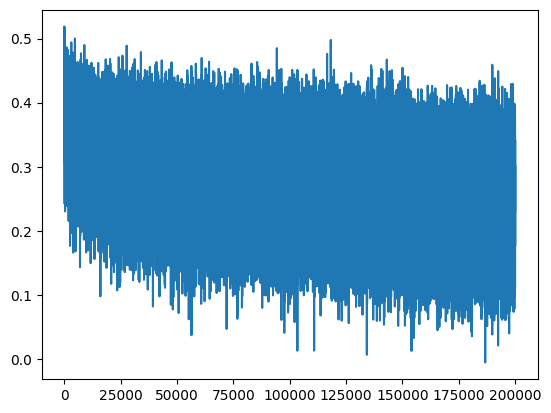

In [207]:
# Loss is crazy because 32 batch elements is too small - luck matters a lot then
plt.plot(lossi)

tensor([[0.5175, 0.5139, 0.5132,  ..., 0.3532, 0.2921, 0.3917],
        [0.3367, 0.3645, 0.3730,  ..., 0.4025, 0.3877, 0.3663],
        [0.3052, 0.3735, 0.3212,  ..., 0.3172, 0.3566, 0.3656],
        ...,
        [0.2322, 0.2281, 0.2982,  ..., 0.3237, 0.2751, 0.3541],
        [0.2308, 0.2367, 0.1874,  ..., 0.2865, 0.2535, 0.2883],
        [0.3237, 0.1446, 0.2567,  ..., 0.2277, 0.2359, 0.2305]])
[0.5174558758735657, 0.5138843655586243, 0.5132239460945129, 0.5056267976760864, 0.49381023645401, 0.5188928246498108, 0.4766554832458496, 0.510044276714325, 0.4815656244754791, 0.46297964453697205]


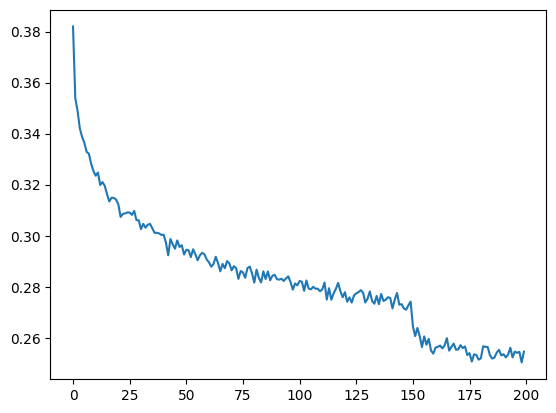

In [208]:
# Let's fix the above graph!
# The above occurs because the batch size are too small - so let's average multiple batches to get a middle ground!
torch.tensor(lossi).view(-1, 1000).shape
# Rearranged across rows and then columns
# Tensor of 200, 1000
print(torch.tensor(lossi).view(-1, 1000))
print(lossi[0:10])

# So we want to mean across the columns
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))
# Now we have a much more readable / understandable graph!
# The dip in loss is due to the learning rate decay!

In [209]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [210]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7682864665985107
val 1.9879884719848633


In [211]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

braxzley.
raniel.
makin.
elve.
hendrix.
kealah.
muaz.
lor.
lucie.
lacen.
zecieio.
dulmee.
kallan.
damiah.
yasmi.
hriston.
mijuleas.
mian.
makeila.
malayah.


In [116]:
# Let's now redo the forward pass to be less code!
# In the below code, 
# This does the embedding
# emb = C[torch.tensor([context])]
# This does the falttening
# x = emb.view(emb.shape[0], -1)
# Why don't we just make these layers!
# We can then add this to our layers!

In [117]:
# We can then create a sequential class (as in pytorch)
# This can be used to programatically string together layers
# And call them one after another (essentailly making a model)

# So instead of saying 
# for layer in layers:
#   x = layer(x)

# you can say logits = model(x)

In [118]:
# Now - let's make our NN bigger and deeper!
# One issue we have right now, is that we squash all three characters in just one layer
# We want to gradually squash them over multiple layers.
# I.E, two characters in layer 1, 2 + 2 = 4 characters in layer 2, etc
# So let's just start off by changing block size from 3 - 8!

In [159]:
# Walking through how we'd do this
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
Xb.shape, Yb.shape
logits = model(Xb)

print(Xb.shape)
print(Xb)

# Output of embedding layer
print(model.layers[0].out.shape)

# Output of flattening layer
print(model.layers[1].out.shape)

# Output of linear layer
print(model.layers[2].out.shape)

# Linear layer is 
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
# If we do something like this
(torch.randn(4, 20, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
# The matrix multiplciation still works! (it only uses the last dimension to check)
# Think of this visually - I believe it's like you're doing the matrix multiplication on the last two dimensions
# Of one matrix, and the first two dimensions of the second matrix 4 times
# Proof
M1 = torch.randn(2, 20, 80)
M2 = M1[0]
M3 = torch.randn(80, 200)

# print(M2 @ M3)
# print((M1 @ M3)[0])
print(torch.allclose(M2 @ M3, (M1 @ M3)[0], atol=1e-5))

# So if we refactor to two characters for a layer, we can do
print((torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape)

# So with this in mind
# We need to change the flatten layer, so it outputs 4, 4, 20
# And change the linear layer, so it outputs 
# 4, 4, 200

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0, 10,  1,  9, 22],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 11],
        [ 0,  0,  0,  0,  6,  1,  8,  9]])
torch.Size([4, 8, 10])
torch.Size([4, 80])
torch.Size([4, 200])
True
torch.Size([4, 4, 200])


In [ ]:
# For flatten layer
# Currently we have 
e = torch.rand(4, 8, 10) # We want (4, 4, 20)
# So
# Here we're taking the even and odd elements in the 2nd dim and concatenating them together
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)

# But a view does the same thing
n_layers = 2
new_e = e.view(4, int(block_size / n_layers), int(n_embd * n_layers))

(new_e == explicit).all()

# So now let's modify flatten
# We'll call it flattenconsecutive since the api diverges from pytorch

tensor(True)

In [180]:
# Inspection code
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 200)
BatchNorm1d : (32, 4, 200)
Tanh : (32, 4, 200)
FlattenConsecutive : (32, 2, 400)
Linear : (32, 2, 200)
BatchNorm1d : (32, 2, 200)
Tanh : (32, 2, 200)
FlattenConsecutive : (32, 400)
Linear : (32, 200)
BatchNorm1d : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


In [ ]:
# Now let's do it hierarchly
# Gonna change the n_hidden to 68 instead of 200
# As the number of parameters is about the same then (22,000)
# However, when we do this - loss is essentially the same lol
# But there is a bug with the batchnorm layer!
# Batchnorm works because everything broadcasts, but the logic is wrong!

In [190]:
# Let's dive into the code
e = torch.randn(32, 4, 68)
emean = e.mean(0, keepdim=True) # 1, 4, 68
evar = e.var(0, keepdim=True) # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # 32, 4, 68
ehat.shape

# The issue is we're taking emean and evar over the 0th dimension -
# When we start splitting, we actually want to do both the 0th and 1st dimension!

e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim=True) # 1, 1, 68
evar = e.var((0, 1), keepdim=True) # 1, 1, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # 32, 4, 68
ehat.shape


torch.Size([32, 4, 68])

In [ ]:
# Pytorch has this built in as well, but the ordering is different!
# The sequence length is actually the last dimension!

# Checking the dimension of the running mean 
model.layers[3].running_mean.shape
# 1, 1, 68 - it's correct now!

torch.Size([1, 1, 68])

In [205]:
# Now let's bump up embd to 24 and hidden to 128!

In [219]:
# Why convolutions?
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print("".join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

# forward a single example:
logits = model( Xtr[[7]] )
print(logits.shape)

# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7 + i]])
print(logits.shape)


# Essentially, a convolution let's you do the for loop at the cuda kernel level
# And you get a lot of intelligent reuse

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
torch.Size([1, 27])
torch.Size([8, 27])


In [220]:
# In the above, we've just reimplemented torch.nn
# From now on, we'll just use torch.nn

In [221]:
# This also shows us how development works for neural networks
# 1) Reading lots of documentation
# 2) There's a lot of matrix multiplication magic
# 3) Prototype in jupyter notebook (develop in jupyter notebook, move it over to vscode)

In [ ]:
# Keep in mind - we haven't set up an experimental harness - typical deep learning work
# needs this set up - you run a lot of experiments!